In [3]:
from keras.models import load_model
import numpy as np, csv, matplotlib.pyplot as plt, random
from keras import backend as K

TESTING_COUNT = 10
WORDS_COUNT = 133778
EPOCHS = 3

/home/aryan/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
print("Loading model")

MODEL_PATH = '{0} [{1}].hd5'.format(WORDS_COUNT, EPOCHS)
model = load_model(MODEL_PATH)

print("Done!")

Loading model
Done!


In [11]:
def predict():
    print("Reading data")

    W1 = []
    W2 = []
    R = []
    Y = []

    with open(str(WORDS_COUNT) + ".set") as fp:
        i = 0
        for line in fp:
            if TESTING_COUNT and i >= TESTING_COUNT:
                break

            i += 1
            w1, r, w2, y = line.split()
            W1.append([w1])
            W2.append([w2])
            R.append([r])
            Y.append([y])

    W1 = np.asarray(W1)
    W2 = np.asarray(W2)
    R = np.asarray(R)
    Y = np.asarray(Y)

    print("Done!")

    print("Start predicting")
    result = model.predict([W1, W2, R])
    print("Done")

    print("Evaluating result")
    acc_count = 0

    for r, y in zip(result, Y):
        t1 = round(r[0])
        t2 = float(y[0])
        if t1 == t2:
            acc_count += 1
        # else:
        #     print('-', t2-r[0])

    print((100*acc_count/(TESTING_COUNT if TESTING_COUNT else len(Y))), "acc")

    print("Done!")

def get_vectors(kfunc, getting):
    print("Getting {0} from file".format(getting))
    items = {}
    ids = []
    with open("{0}.{1}.csv".format(str(WORDS_COUNT), getting)) as fd:
        reader = csv.reader(fd)
        for i, w in reader:
            items[i] = w
            ids.append([i])
    ids = np.asarray(ids)
    print("Done!")
    print("Getting vectors")
    temp = kfunc([ids])[0]
    for i, v in zip(ids, temp):
        i, v = i[0], (v[0] if getting == 'words' else v)
        items[i] = (items[i], v)
    print("Done!")
    return items


def get_words_vectors():
    kfunc = K.function(
        [model.layers[1].input],
        [model.layers[3].get_output_at(0)]
    )

    return get_vectors(kfunc, 'words')

def get_rels_vectors():
    kfunc = K.function(
        [model.layers[0].input],
        [model.layers[4].output]
    )
    
    return get_vectors(kfunc, 'rels')
    

In [ ]:
# predict()
words_vectors = get_words_vectors()


Getting words from file


1336


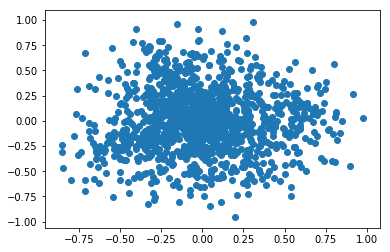

In [5]:
from sklearn.manifold import SpectralEmbedding

PLOT_PC = .01
words = [words_vectors[k][0] for k in words_vectors]
random.shuffle(words)
sample_words = words[:int(len(words)*PLOT_PC)]
sample_vectors = [words_vectors[k][1] for k in words_vectors if words_vectors[k][0] in sample_words]
print(len(sample_vectors))
vectors = np.asarray(sample_vectors)
reduced_vectors = SpectralEmbedding().fit_transform(vectors)

plt.scatter(reduced_vectors[:,0], reduced_vectors[:,1])
plt.savefig('sample.png')

In [5]:
data = []
rel_data = {}
with open(str(WORDS_COUNT) + '.set') as fd:
    for l in fd:
        temp = l.split()
        data.append(temp)
        if temp[1] not in rel_data:
            rel_data[temp[1]] = []
        rel_data[temp[1]].append(temp)


In [6]:
from math import sqrt
def distance(v1, v2):
    acum=0
    for x,y in zip(v1,v2):
        acum+= (x-y)**2
    return sqrt(acum)

In [ ]:
# Distancias por relacion
count = 5
for k in rel_data:
    print("Distance in", k)
    dist = []
    for w1,_,w2,v in rel_data[k]:
        dist.append((words_vectors[w1][0], words_vectors[w2][0] ,distance(words_vectors[w1][1], words_vectors[w2][1]), v))
    dist.sort(key=lambda x:x[2])
    print('N |', dist[:count])
    print('F |', dist[-count:])
    print("==================================================================")

In [7]:
dist0 = [0,0,0,0]
dist1 = [0,0,0,0]
for w1,r,w2,v in data:
    d = distance(words_vectors[w1][1], words_vectors[w2][1])
    temp = dist0 if v == "0" else dist1
    temp[int(np.floor(d))]+=1
print(dist0, dist1)

[1263, 81088, 72891, 600] [43728, 109611, 2501, 9]


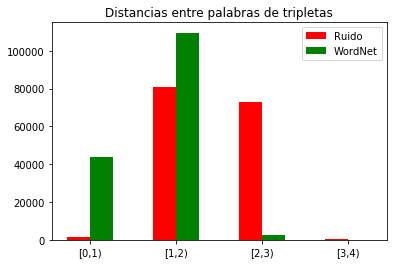

In [8]:
locs = np.arange(0,4)
tags = map(lambda x: '[{0},{1})'.format(x,x+1), locs)
width = .27
plt.title('Distancias entre palabras de tripletas')
plt.bar(locs, dist0, width=width, color='red', label='Ruido')
plt.bar(locs+width, dist1, width=width, color='green', label='WordNet')
plt.legend()
plt.xticks(locs + width/2, tags)
plt.savefig('distances.png')

### Relaciones

In [13]:
# rels_vectors = get_rels_vectors()
# syn_matrix = rels_vectors['0'][1]
# for r in syn_matrix:
#     for c in r:
        

Getting rels from file
Done!
Getting vectors
Done!
[[ 3.205439    0.15534322  0.3862151  ...  0.89526945 -0.25226077
   1.0657418 ]
 [-0.8692908   0.70330924  0.77951515 ... -0.30769128 -1.2400936
  -1.4745831 ]
 [ 0.00993303  0.6095723   1.9775661  ...  1.8570808   0.26808506
  -1.0612062 ]
 ...
 [ 0.70308965 -1.0529064   1.5075861  ... -0.1310533  -0.03812264
   0.17967269]
 [-0.31422713 -1.7696784  -0.26533222 ... -0.3837282   2.065647
   0.43428966]
 [ 1.0013931  -1.2048097  -0.47904685 ... -0.3280215   0.6723618
   2.458314  ]]


In [8]:
from nltk.corpus import movie_reviews

In [9]:
movie_reviews.sents()

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  Searched in:
    - '/home/aryan/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - ''
**********************************************************************
